# ArchPy2Modflow: Unstructured Grids

## Create ArchPy model

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

%load_ext autoreload
%autoreload 2

In [2]:
pv.set_jupyter_backend('static')

In [3]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 140
ny = 70
nz = 70
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [4]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential", {"w":.21,"r":[50, 50, 10]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B1 = gcm.CovModel3D(elem=[("exponential", {"w":.16,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B2 = gcm.CovModel3D(elem=[("exponential", {"w":.24,"r":[100, 100, 3]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B3 = gcm.CovModel3D(elem=[("exponential", {"w":.19,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B4 = gcm.CovModel3D(elem=[("exponential", {"w":.13,"r":[100, 100, 4]})], alpha=0, name="vario_SIS") # input variogram

lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelB=[covmodel_SIS_B1, covmodel_SIS_B2, covmodel_SIS_B3, covmodel_SIS_B4] # list of covmodels to pass


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-6.5}
dic_f_C = {"f_method" : "SIS","neig" : 10, "f_covmodel":lst_covmodelC, "probability":[0.3, 0.7]}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-8.5}
dic_f_B = {"f_method":"SIS", "neig" : 10, "f_covmodel":lst_covmodelB, "probability":[0.2, 0.4, 0.25, 0.15]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-11}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=5,ID = 5,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [46]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_3, facies_5])
D.add_facies([facies_1])
C.add_facies([facies_4, facies_6])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2]
means = [-4, -2, -6, -9, -6, -7, -19]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = list_covmodels,
                                means = means,
                                int_method = "sgs",
                                vmin = -10,
                                vmax = -1
                                )

cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.005, "r":[10, 10, 10]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.005, "r":[25, 25, 25]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop1]

Porosity = ArchPy.base.Prop("Porosity",
                            facies = list_facies,
                            covmodels = list_covmodels,
                            means = [0.2, 0.25, 0.15, 0.1, 0.15, 0.2, 0.05],
                            int_method = ["sgs","sgs","sgs","sgs","sgs","sgs","homogenous"],
                            vmin = 0,
                            vmax = 0.4
                            )


object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added
object isn't a Facies object or Facies object has already been added


In [47]:
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

In [48]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot, rotation_angle=45)
T1.add_prop([prop_model, Porosity])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added
Property Porosity added


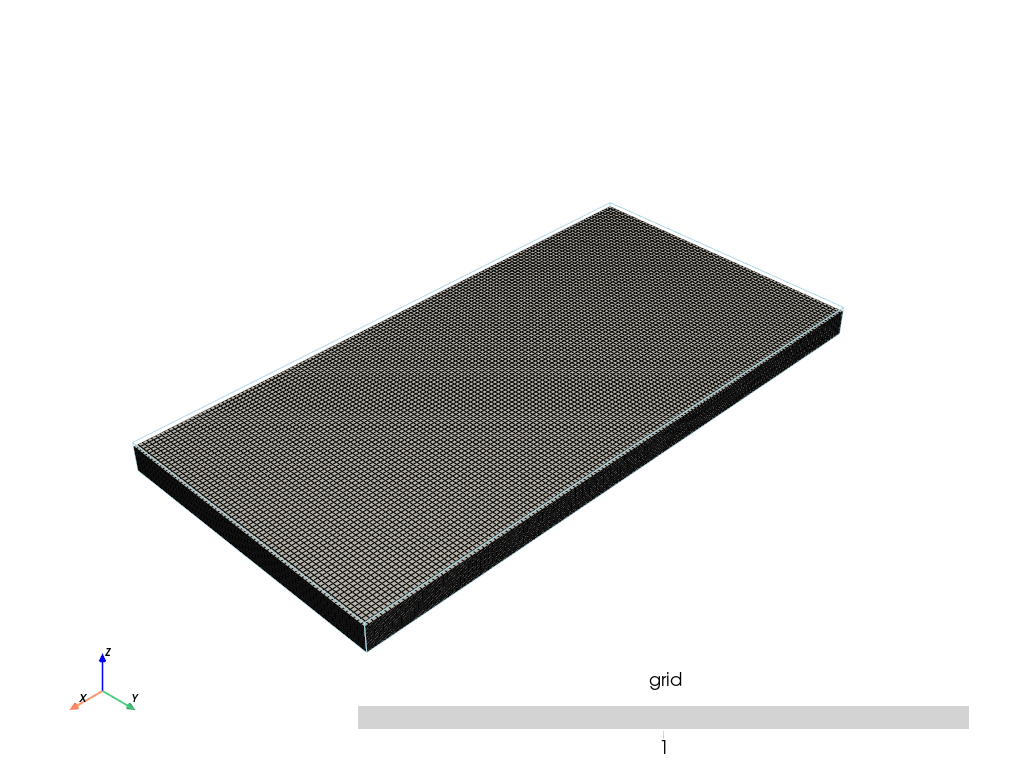

In [49]:
T1.plot_grid()

In [50]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0359044075012207 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.026927471160888672 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.03291487693786621 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.09880423545837402 s
##########################


### 0.20682549476623535: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
Time elapsed 1.15 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ###
Time e

In [51]:
import flopy as fp

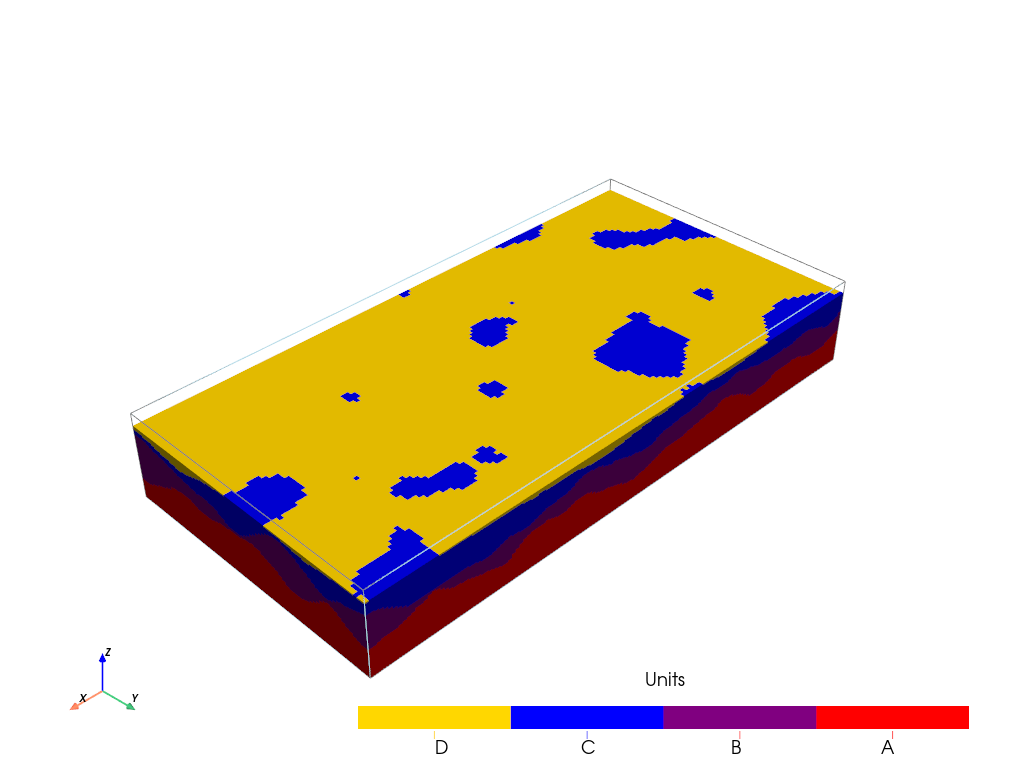

In [52]:
T1.plot_units(v_ex=3)

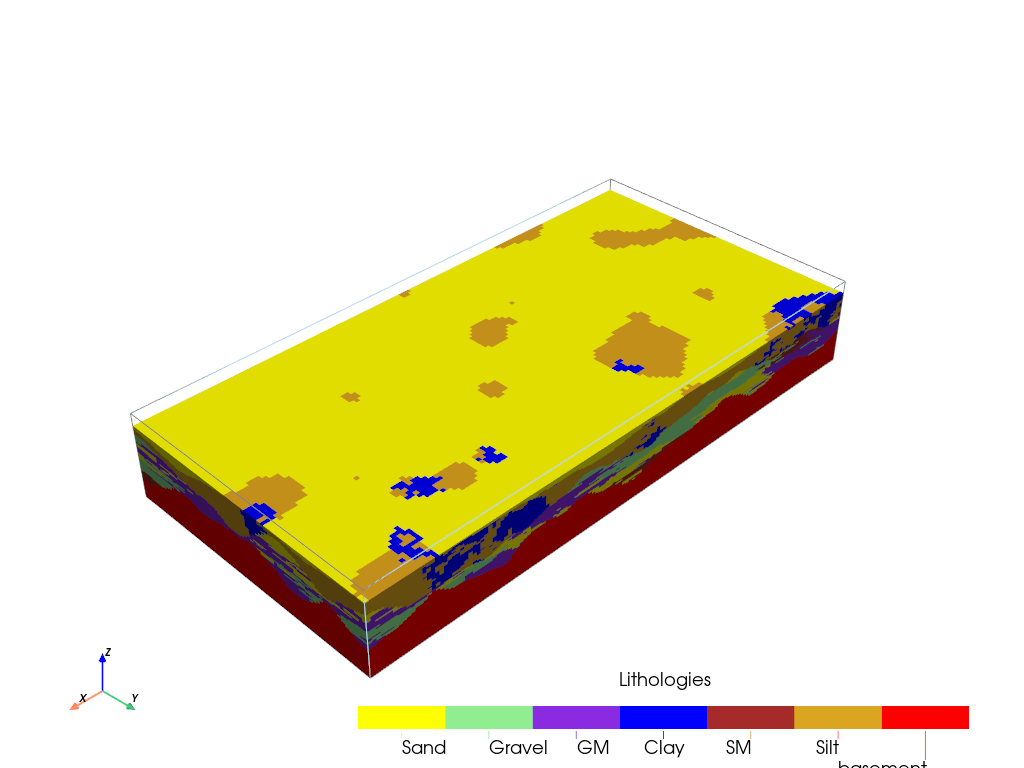

In [53]:
T1.plot_facies(v_ex=3)

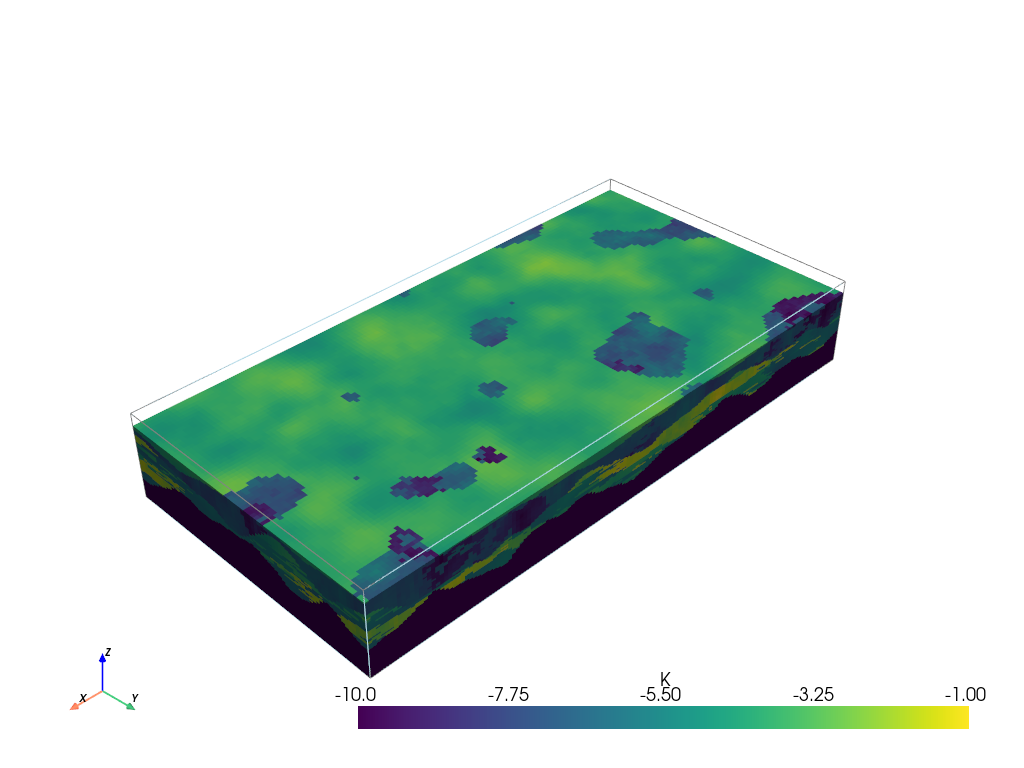

In [54]:
T1.plot_prop("K", v_ex=3)

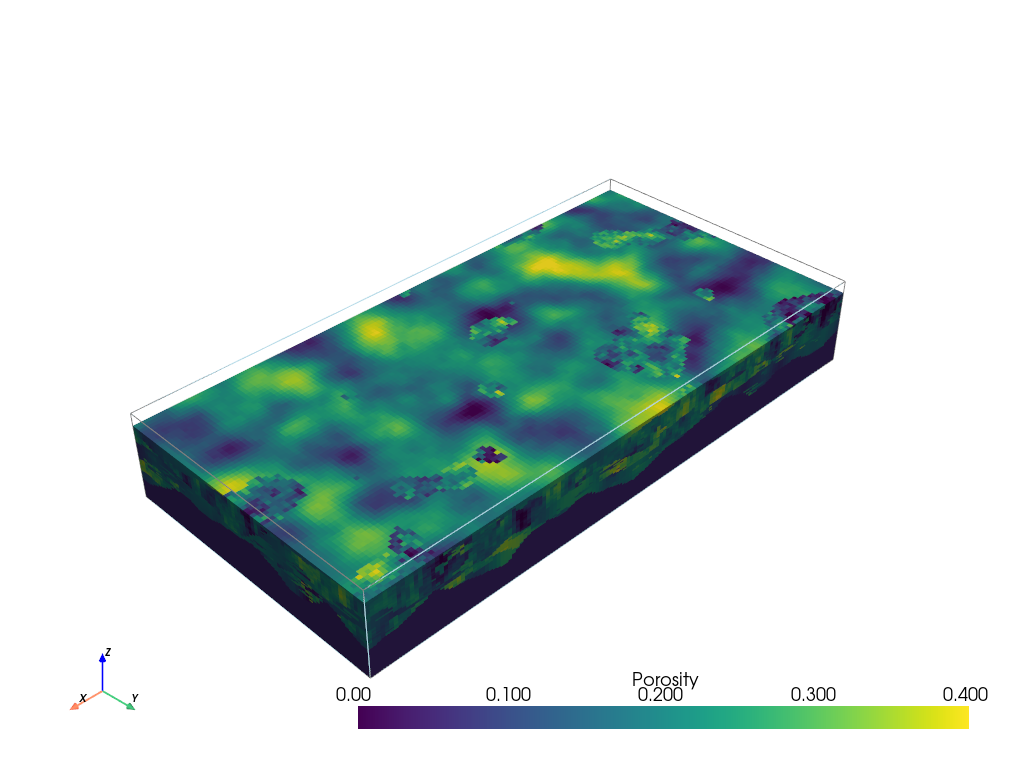

In [97]:
T1.plot_prop("Porosity", v_ex=3)

In [56]:
val = T1.get_prop("K")[0, 0, 0]
im = geone.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=x0, oy=y0, oz=z0, nv=1, val=val)

In [57]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

## Create a modflow grid 

(can be disv or disu)

In [58]:
import flopy
from flopy.utils.gridgen import Gridgen
from flopy.export.vtk import Vtk

gridgen_path = "../../../../exe/gridgen.exe"

In [188]:
# create a grid  --> we can create a fake modflow model to use the gridgen

# 3D example
# grid dimensions
nlay = 4
nrow = 16
ncol = 24
delr = 8.5
delc = 6.
top = -6
ox = 0
oy = 5
rot_angle = T1.rot_angle

botm = np.linspace(-6.5, -15, nlay)

sim = flopy.mf6.MFSimulation(
    sim_name="asdf", sim_ws="ws", exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]])
ms = flopy.mf6.ModflowGwf(sim, modelname="asdf", save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=0,  # gridgen will be applied on a grid with origin at 0, 0
    yorigin=0,
    angrot=rot_angle,
)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws="gridgen_ws", exe_name=gridgen_path)  

polygon = [
    [
        (70, 140),
        (70, 130),
        (40, 120),
        (40, 120),
        (70, 140),
    ]
]
polygon = np.array(polygon)
polygon = polygon - [ox, oy]  # move the polygon to the origin

g.add_refinement_features([polygon], "polygon", 4, range(1))
refshp0 = "gridgen_ws/" + "rf0"

In [189]:
g.build(verbose=False)

In [190]:
ms.dis.remove()
# disv_gridprops = g.get_gridprops_disv()
# disv = flopy.mf6.ModflowGwfdisv(ms, **disv_gridprops, xorigin=ox, yorigin=oy, angrot=0)  # create grid this time with the origin at ox, oy
disu = flopy.mf6.ModflowGwfdisu(ms, **g.get_gridprops_disu6(), xorigin=ox, yorigin=oy, angrot=0)  # create grid this time with the origin at ox, oy

Little check to verify that modflow model is at least smaller than the ArchPy model

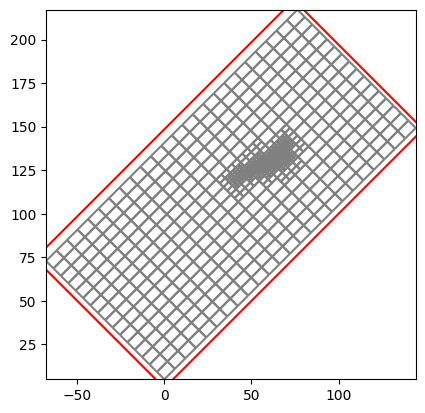

In [191]:
grid = ms.modelgrid
grid.plot()

# get bounding box archpy
points_box = T1.get_points_box()

# plot the bounding box
plt.plot(points_box[:, 0], points_box[:, 1], "r-")

In [192]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids
from ArchPy.uppy import upscale_k, rotate_point

In [193]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")  # create the modflow model
archpy_flow.create_sim(grid_mode="disu", iu=0, unit_limit=None,
                       factor_x=7, factor_y=7, factor_z=7,
                       modflowgrid_props=g.get_gridprops_disu6(), xorigin=ox, yorigin=oy, angrot=rot_angle)  # create the simulation

Simulation created
To retrieve the simulation, use the get_sim() method


In [194]:
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, upscaling_method="simplified_renormalization")  # set the hydraulic conductivity

In [195]:
sim = archpy_flow.get_sim()  # get the simulation object
gwf = archpy_flow.get_gwf()  # get the groundwater flow model object

Plot to see the upscaled K field 

In [196]:
k = gwf.npf.k.array  # get the hydraulic conductivity array
k22 = gwf.npf.k22.array  # get the hydraulic conductivity array
k33 = gwf.npf.k33.array  # get the vertical hydraulic conductivity array
Porosity = archpy_flow.upscale_prop("Porosity")

In [197]:
vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

vtk.add_array(np.log10(k), name="K")
vtk.add_array(np.log10(k33), name="K33")
vtk.add_array(np.log10(k22), name="K22")
vtk.add_array(Porosity, name="Porosity")
gwf_mesh = vtk.to_pyvista()

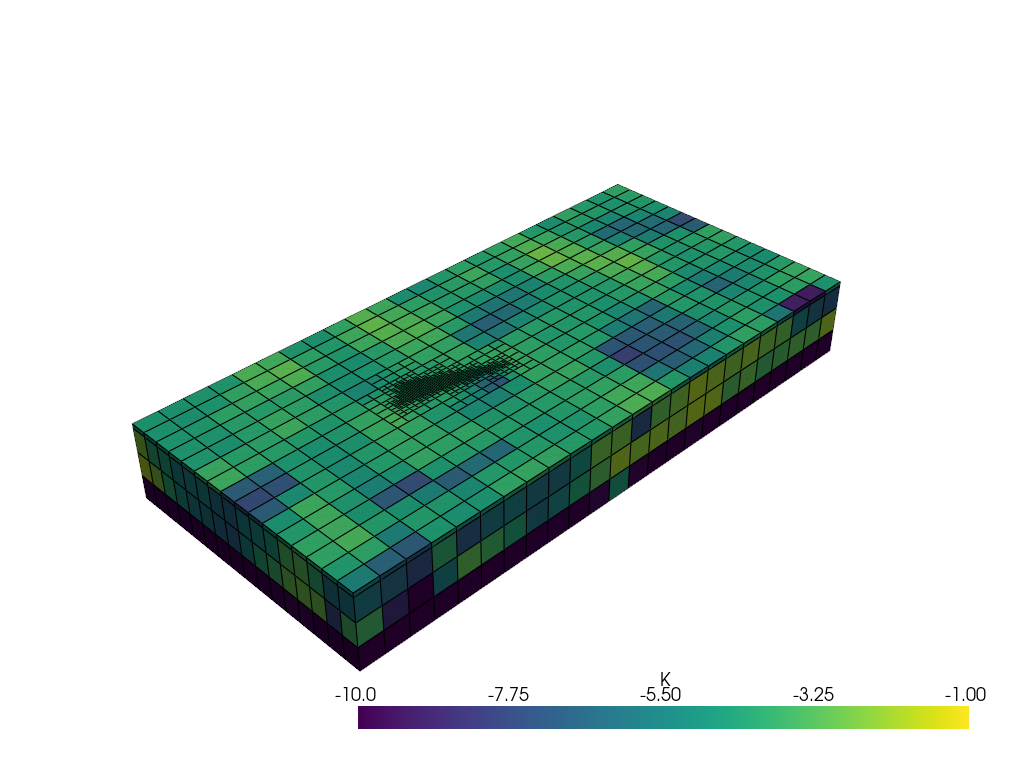

In [198]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="K", clim=[-10, -1])
pl.show()

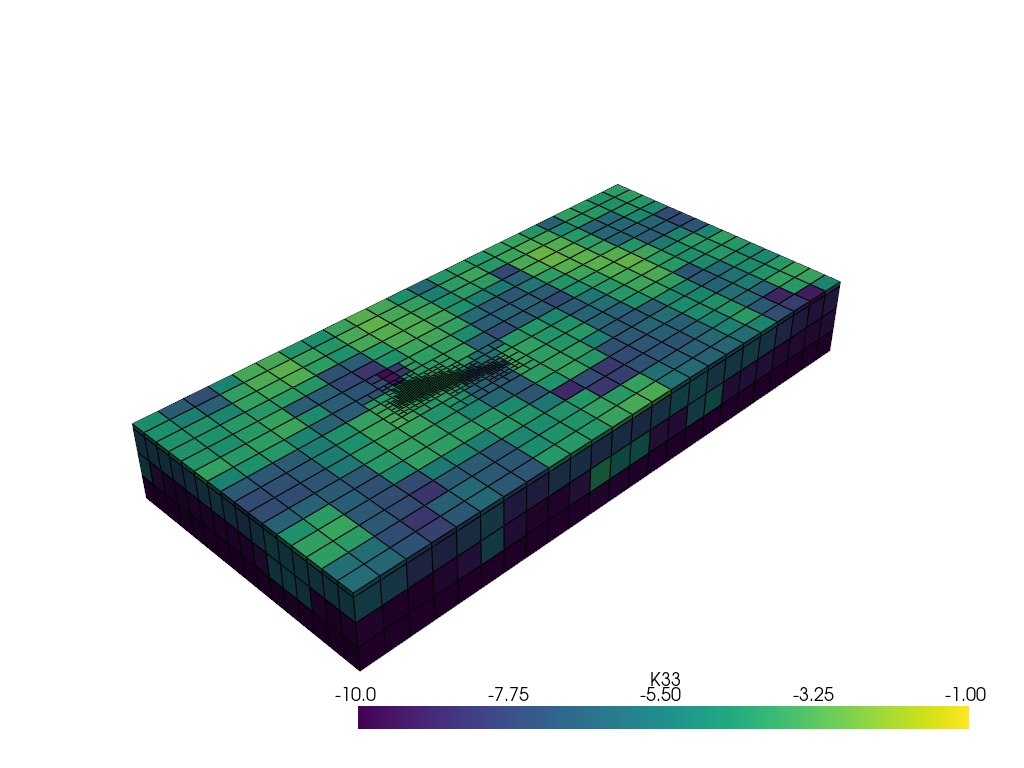

In [199]:
import pyvista as pv

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="K33", clim=[-10, -1])
pl.show()

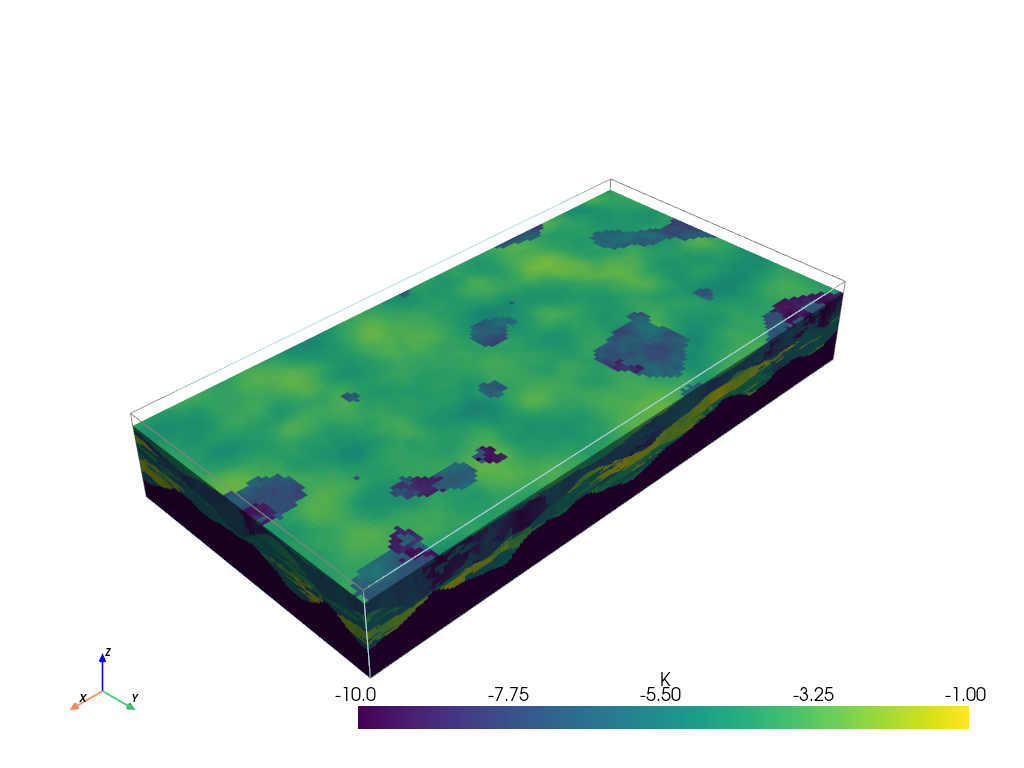

In [200]:
T1.plot_prop("K", v_ex=3)

Plot of porosity

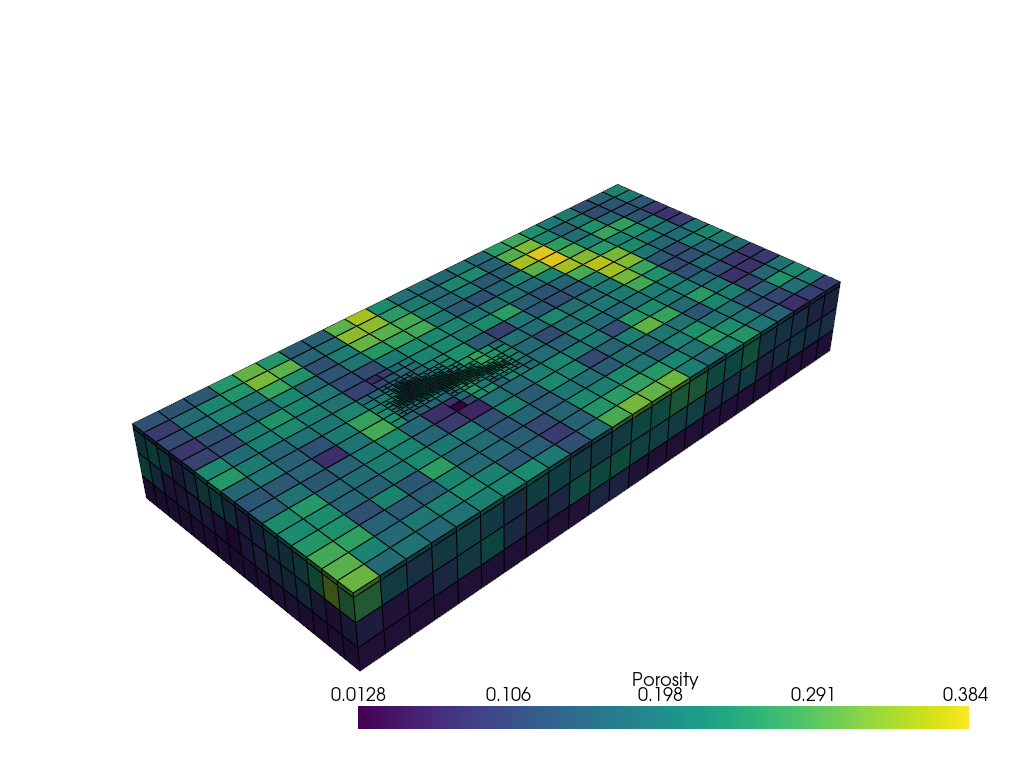

In [201]:
import pyvista as pv

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Porosity")
pl.show()

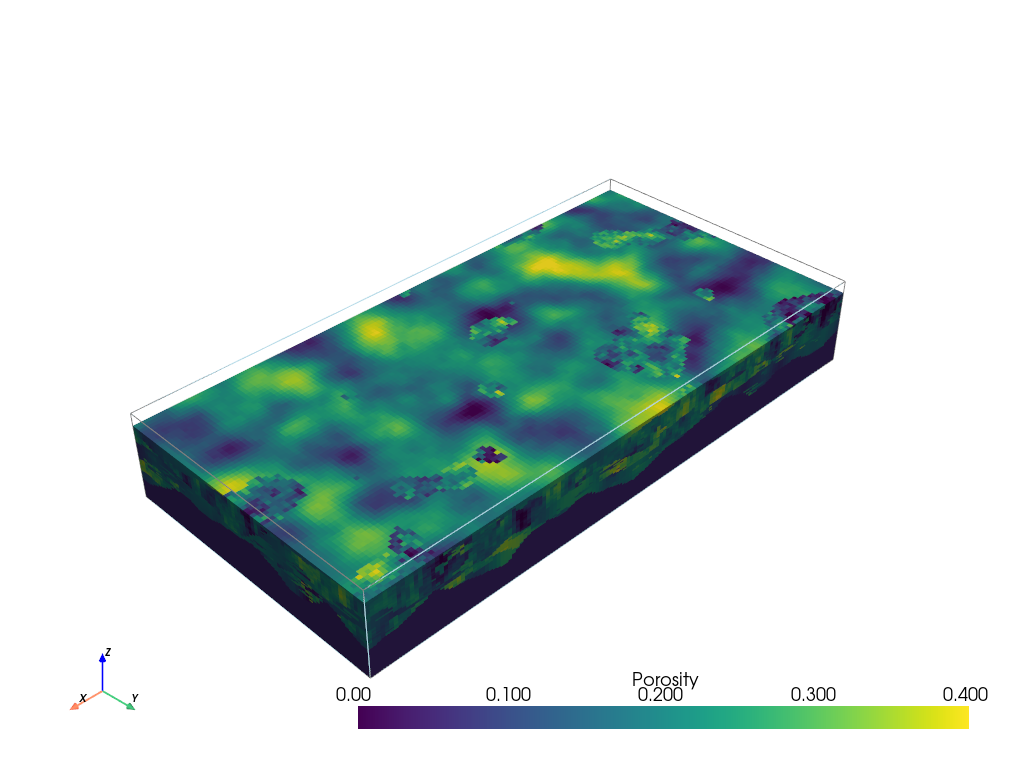

In [202]:
T1.plot_prop("Porosity", v_ex=3)

We can also investigate the anisotropic ratio (kx over kz)

In [203]:
vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

arr = np.log10(k / k33)
# arr = gwf.dis.idomain.array
vtk.add_array(arr, name="Kxx/Kzz")
gwf_mesh = vtk.to_pyvista()


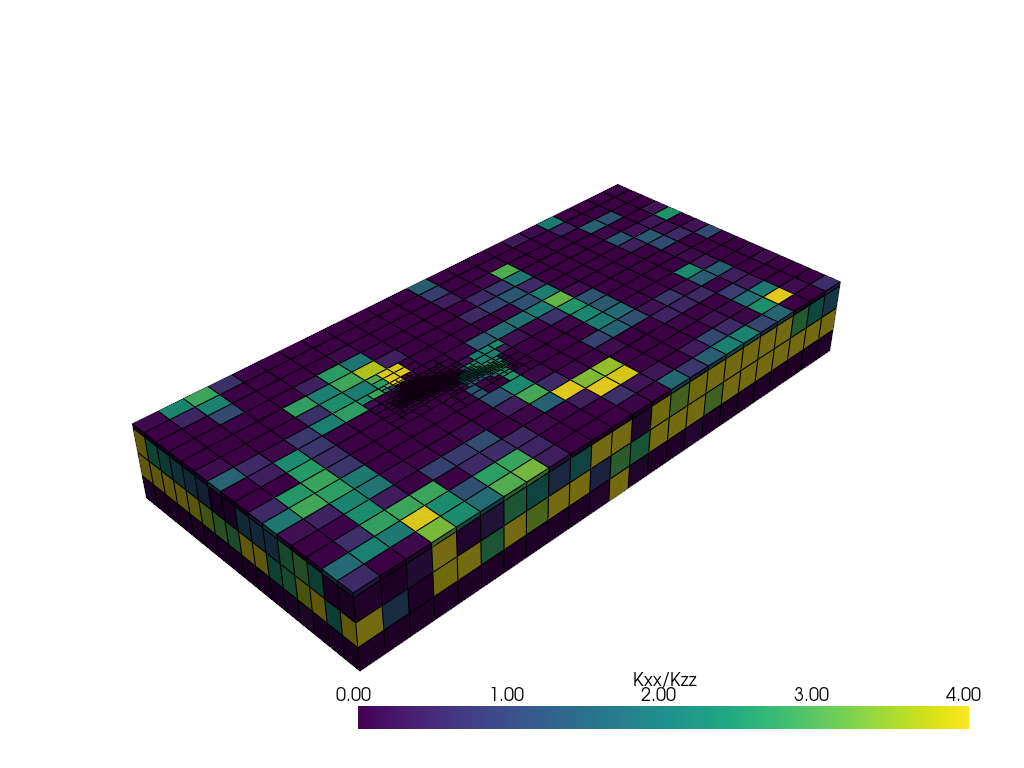

In [204]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Kxx/Kzz", clim=[0, 4])
pl.show()

We can see that in many cells, the anisotropy ratio is exceeding 1000 --> refleting the heterogeneity of the model